# Notebook 00: Data preprocessing and the baseline model

In this notebook, we inspect the `PubMed` data that will be used for this practice multi-class classification project. I will also build some models using non-neural network methods. From these models, I will pick our baseline model for our development of a neural network model. For this notebook only, I will not use GPU. All later notebooks will employ GPU to boost computations.

The `PubMed` data is a dataset of medical paper abstracts. In the dataset, the abstracts are splitted by sentences and each sentence is labeled by either `OBJECTIVE`, `METHODS`, `RESULTS`, `BACKGROUND`, and `CONCLUSIONS`. Moreover, the data are already splitted into `train`, `dev`, and `test`. I will use `train` and `dev` to develop the models. Finally, in the last notebook, I use `test` to see how our final deep neural network model handles unseen data.

>[Notebook 00: Data preprocessing and the baseline model](#scrollTo=1e9uKq4VaKnL)

>>[0.1 Load needed libraries and functions](#scrollTo=P2lmp4MQ2HAZ)

>>[0.2 Load data](#scrollTo=JkQoMaWAbVxe)

>>>[0.2.1 Preprocess data](#scrollTo=-G7b_G8EbY-i)

>>[0.3 The Baseline model](#scrollTo=KHaZH3fAB_gj)

>>>[0.3.1 Naive Bayes](#scrollTo=sxJDUxpKCCgu)

>>>[0.3.2 Random Forests](#scrollTo=LDf8uN7-GpuG)

>>>[0.3.3 Select the baseline model](#scrollTo=DNxJruqXKqW2)



## 0.1 Load needed libraries and functions

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

I have also organized some my own customized utility functions in a separate `.py` file. Here I import the file from my project directory on github.

In [2]:
!wget https://raw.githubusercontent.com/ZYWZong/ML_Practice_Projects/refs/heads/main/SkimLit_project_practice/SkimLit_utils.py

--2024-12-24 23:33:40--  https://raw.githubusercontent.com/ZYWZong/ML_Practice_Projects/refs/heads/main/SkimLit_project_practice/SkimLit_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2884 (2.8K) [text/plain]
Saving to: ‘SkimLit_utils.py’

SkimLit_utils.py    100%[===================>]   2.82K  --.-KB/s    in 0s      

2024-12-24 23:33:40 (41.9 MB/s) - ‘SkimLit_utils.py’ saved [2884/2884]



In [17]:
from SkimLit_utils import *

## 0.2 Load data

Fetching the labeled `PubMed` data from *Franck Dernoncourt*'s github.


In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 19.27 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Let us inspect a few samples from the `train.txt` file, which contains the training data. As seen below, each line of an abstract is labeled as either `OBJECTIVE`, `METHODS`, `RESULTS`, `BACKGROUND`, and `CONCLUSIONS`. Later, we will preprocess the data and create categorical and quantitative features from them.




In [18]:
# Inspect samples of the training data
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
read_lines(data_dir+"train.txt")[:16]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

The data is already splitted into `train`, `dev`, and `test` sets. We load them accordingly.

In [6]:
train_samples = preprocess_data_with_line_numbers(data_dir + "train.txt")
dev_samples = preprocess_data_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_data_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(dev_samples), len(test_samples)

(180040, 30212, 30135)

From above, I see that the train-dev-test split is about $74\%$-$13\%$-$13\%$, which adheres to the traditional guideline for applying classic statistical learning methods (e.g. Naive Bayes and Random Forests).

### 0.2.1 Preprocess data

Here, we preprocess the data and create features that will be used to train our deep learning models later in the next few notebooks. Notice that we have created a variable for `line_number` to perform positional encoding for our later deep neural network models (see later notebooks).

In [7]:
train_df = pd.DataFrame(train_samples)
dev_df = pd.DataFrame(dev_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(16)

,label,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [8]:
# Create one_hot encoding for the categorical features
# These will be used in the neural network models in later notebooks
train_sentences = train_df["text"].tolist()
dev_sentences = dev_df["text"].tolist()
test_sentences = test_df["text"].tolist()

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["label"].to_numpy().reshape(-1, 1))
dev_labels_one_hot = one_hot_encoder.transform(dev_df["label"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["label"].to_numpy().reshape(-1, 1))

print(train_labels_one_hot[:5])

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [9]:
# Create label encoding to build the baseline models
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["label"].to_numpy())
dev_labels_encoded = label_encoder.transform(dev_df["label"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["label"].to_numpy())

print(train_labels_encoded[:5])

[3 2 2 2 2]


## 0.3 The Baseline model

In this section, I build baseline models using the Naive Bayes and the Random Forest methods. I will pick the best model that has the highest accuracy. Here, I use `scikitlearn`'s `TfidfVectorizer` function to generate encodings for the preprocessed data.

### 0.3.1 Naive Bayes

Let's first try a density method. Let's see how the Naive Bayes performs (Naive Bayes runs very fast, so it is an ideal choice for a first model).

In [10]:
from sklearn.naive_bayes import MultinomialNB

# Create and fit a naive Bayes model using the scikitlearn library
model_Naive_Bayes = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_Naive_Bayes.fit(X=train_sentences,
            y=train_labels_encoded);

# Get the prediction on the development dataset
Naive_Bayes_preds = model_Naive_Bayes.predict(dev_sentences)

print(Naive_Bayes_preds[:5])

[4 1 3 2 2]


In [11]:
# Perform model evaluations
Naive_Bayes_evaluations = perform_evaluations(y_true=dev_labels_encoded, y_pred=Naive_Bayes_preds, model_name = "Naive Bayes")

Naive_Bayes_evaluations_df = pd.DataFrame(Naive_Bayes_evaluations)

Naive_Bayes_evaluations_df.head()

,Metric,Naive Bayes
0,Accuracy,72.18
1,Precision,71.86
2,Recall,72.18
3,F1-score,69.89


### 0.3.2 Random Forests

In addition to the Naive Bayes model, I would like also try the decision-tree method. In particular, I want to see whether a Random Forest model achieves a better accuracy. The ensemble models will run much longer than the Naive Bayes as we are averaging over multiple decision-trees for each ensemble. To perform our Random Forest experiments, I have written the following helper functions:


In [12]:
from sklearn.ensemble import RandomForestClassifier

def RandomForestModels(n_estimators):
  """
  Argument:
    n_estimators (array): an array of estimators
  Return:
    models (list): a list of models
  """
  models = []
  for i in n_estimators:
    model = Pipeline([
      ("tf-idf", TfidfVectorizer()),
      ("clf", RandomForestClassifier(n_estimators=i, random_state=42))
    ])
    models.append(model)
  return models

def RandomForestFit(models, train_sentences, train_labels_encoded):
  """
  Argument:
    models (list): a list of models
    train_sentences (list): a list of training sentences
    train_labels
  Return:
    None (here we pass by reference on the list of models)
  """
  for model in models:
    model.fit(X=train_sentences,y=train_labels_encoded);

def RandomForestPredict(models, dev_sentences):
  """
  Argument:
    models (list): a list of models
    dev_sentences (list): a list of development sentences
  Return:
    preds (list): a list of predictions
  """
  preds = []
  for model in models:
    pred = model.predict(dev_sentences)
    preds.append(pred)
  return preds

def RandomForestEvaluate(n_estimators, models, dev_labels_encoded, preds):
  """
  Argument:
    n_estimators (list): a list of estimators
    models (list): a list of models
    dev_labels_encoded (array): an array of labels
    preds (list): a list of predictions
  Return:
    evaluations (list): a list of evaluations
  """
  evaluations = []
  for i in range(len(models)):
    evaluation = perform_evaluations(y_true=dev_labels_encoded, y_pred=preds[i], model_name = f"Random Forest ({n_estimators[i]})")
    evaluations.append(evaluation)
  return evaluations


def plot_evaluations_RFmodels(evaluations, n_estimators, x_log = False):
  """
  Plot the evaluations for each model

  Argument:
    evaluations (list): a list of evaluations
    n_estimators (list): a list of estimators
    x_log (bool): whether to plot the x-axis in log scale
  Return:
    None
  """
  if x_log:
    x = np.log10(n_estimators)
  else:
    x= n_estimators

  plt.plot(x, [evaluation[f"Random Forest ({n_estimators[i]})"][0] for i, evaluation in enumerate(evaluations)], label="Accuracy", linewidth = 3, color = "orange",  marker='o')
  plt.plot(x, [evaluation[f"Random Forest ({n_estimators[i]})"][1] for i, evaluation in enumerate(evaluations)], label="Precision", color = "deepskyblue", linestyle='dotted', marker='.')
  plt.plot(x, [evaluation[f"Random Forest ({n_estimators[i]})"][2] for i, evaluation in enumerate(evaluations)], label="Recall", color = "darkturquoise", linestyle='dotted',  marker='.')
  plt.plot(x, [evaluation[f"Random Forest ({n_estimators[i]})"][3] for i, evaluation in enumerate(evaluations)], label="F1-score", color = "violet", linestyle='dotted',  marker='.')
  plt.xticks(x)
  plt.xlabel("number of estimators")
  plt.ylabel("score")
  plt.title("Random Forests")
  plt.legend(bbox_to_anchor=(1.0, 1.0))
  plt.show()

Let's try four different sizes of Random Forests: ensembles of 2, 5, 10, and 15 trees.

In [13]:
n_estimators = [2,5,10,15]

models = RandomForestModels(n_estimators)

Next, we fit our model. WARNING: The code below takes some time to run on CPU.

In [14]:
RandomForestFit(models, train_sentences, train_labels_encoded)

And, let's see how the models perform.

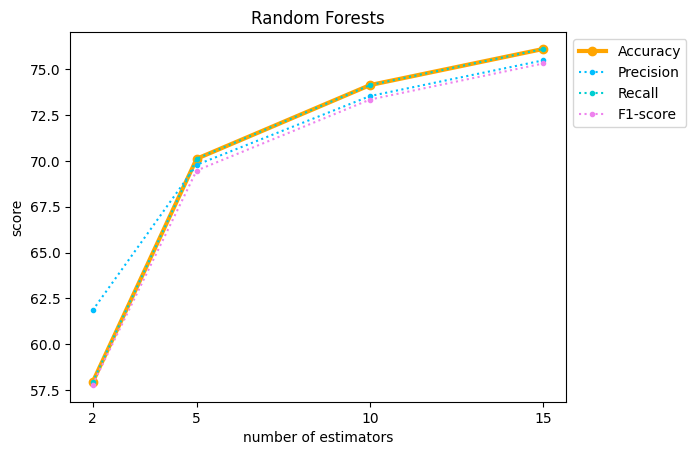

In [15]:
preds_dev = RandomForestPredict(models, dev_sentences)
evaluations = RandomForestEvaluate(n_estimators, models, dev_labels_encoded, preds_dev)
plot_evaluations_RFmodels(evaluations, n_estimators)

From the above plot, we see that the `accuracy` starts to plateau towards the end. Of course, ideally, I should also continue to increase the number of trees to find a balance between `accuracy` and, say, `runtime`, which may be another satisfying metric other than the `F-1 score` etc. However, for the purpose of this practice project, I will end here.

### 0.3.3 Select the baseline model

Now, combine our results from the Naive Bayes and the Random Forest models.

In [16]:
joined_df = Naive_Bayes_evaluations_df
for evaluation in evaluations:
  evaluation_df = pd.DataFrame(evaluation)
  joined_df = pd.merge(joined_df, evaluation_df, on="Metric")

joined_df.set_index("Metric", inplace=True)

joined_df

,Naive Bayes,Random Forest (2),Random Forest (5),Random Forest (10),Random Forest (15)
Metric,,,,,
Accuracy,72.18,57.92,70.11,74.13,76.10
Precision,71.86,61.84,69.78,73.53,75.48
Recall,72.18,57.92,70.11,74.13,76.10
F1-score,69.89,57.78,69.47,73.34,75.31


Based on the accuracy score, I select my 15 trees Random Forest model as my baseline model.